# Real vs random clusters

In this notebook I tried to reproduce the graphs from Williams et al. 2013 paper in order to find the most optimal parameters via selecting the smaller ratio of random to real clusters. I also plotted compositions across the $d_{max}$ values and cluster sizes. The cluster composition correction was simplified:
- Fe ions column were deleted from the corrected data sets,
- Fm ions were multiplied by 0.92 as usually 8% of this peak overlaps with Fe ions,
- remaning Fm ions were added to Ni ions.

A python function based on this notebook will be added soon.

In [32]:
import xml_for_msm_with_relabelling as pgp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import subprocess
import pandas
import time
import sys

In [2]:
output_folder = "examples/" 
pos_file_path="" #R5083_09569-v08-roi_noOx.pos
range_file_path="R053_....rng" #R5083_09569-v08_noOx.rrng
random_runs = 5

In [3]:
#Check for pos file existing, 
if not os.path.isfile(pos_file_path) and not len(pos_file_path):
    #This is hard-coded in the XML file. Could switch to -pos generation.
    pos_file_path = "posgenpyTest_easy.pos"
    
    #Generate the file using the example
    if
        print('Generating synthetic pos input')

        if not subprocess.call(["posgen", "examples/generateTestPos_easy.xml"]) == 0:
            print('Generating example pos using posgen failed')
            assert(False)
        else:
            print('Complete')
    
    range_file_path="examples/posgenpyTest.rng"

if not os.path.isfile(pos_file_path):
    print(f'input pos file not found {pos_file_path}')
    assert(False)

Generating synthetic pos input
Complete


### Iterate through multiple dmax values with random data

In [3]:
dmax_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [10]:
xml_files = []
output_basename="output_{i}_dmax_{dm}"
for i, dm in enumerate(dmax_values):
    thisName = output_basename.format(i=i,dm=dm)
    xml_output = pgp.write_xml_with_relabelling(xmlFileName=thisName,
                                                posFile=pos_file_path,
                                                rangeFile=range_file_path,
                                                coreIons=["Fm", "Ni", "P", "Cu", "Mn", "Si"],
                                                bulkIons=["Fe", "Mo", "C"],
                                                relabelled_runs=10,
                                                destination_folder=output_folder,
                                                knn=7,
                                                nminV=5,
                                                dmax=dm
                                  )
    output_file = output_folder+os.sep + str(thisName) + ".xml"
    xml_files.append(output_file)

TODO: change the dmax values in the folders so that they dont include full stop as it might cause some problems later

In [12]:
xml_files = []
for i, dm, in enumerate(dmax_values):
    xml_files.append(output_folder+output_basename.format(i=i,dm=dm))

for x in xml_files:
    print(x)

examples/output_0_dmax_0.2
examples/output_1_dmax_0.3
examples/output_2_dmax_0.4
examples/output_3_dmax_0.5
examples/output_4_dmax_0.6
examples/output_5_dmax_0.7


In [13]:
os.chdir(posgen_folder)

NameError: name 'posgen_folder' is not defined

In [ ]:
for i, xml_file in enumerate(xml_files):
    posgen_output = subprocess.call(["posgen", xml_file.replace("/", "\\")])
    print(f"File {i} analysed")

### Plotting threshold value
$(N_{real} - N_{rand})/N_{real}$

In [30]:
# find average number of random clusters for each dmax
average_random_all_dm = []
for i, dm in enumerate(dmax_values):
    all_random_clusters = []
    for random_run in range(random_runs):
        # deconstruct the full file name and import it into pandas dataframe
        local_size_dist_file = f"{output_folder}przemek_{i}_dmax_{dm}_random_{random_run + 1}_sizedist.txt"
        local_df = pandas.read_csv(local_size_dist_file, sep="\t")
        
        # find the total number of clusters by summing up Size(core) column
        loc_size_core = local_df["Frequency "]
        loc_clusters = loc_size_core.sum()
        
        all_random_clusters.append(loc_clusters)
    # calculate average of all random clusters and put it in average random all dm
    print(f"Random clusters for D_max = {dm}: {all_random_clusters}")
    average_random_all_dm.append(np.mean(all_random_clusters))

print(f"Averages for all D_max values: {average_random_all_dm}")

Random clusters for D_max = 0.2: [2, 1, 1, 0, 0]
Random clusters for D_max = 0.3: [225, 125, 88, 75, 69]
Random clusters for D_max = 0.4: [2249, 1333, 1040, 896, 810]
Random clusters for D_max = 0.5: [5523, 4047, 3458, 3124, 2954]
Random clusters for D_max = 0.6: [3763, 3368, 2944, 2721, 2547]
Random clusters for D_max = 0.7: [1276, 1639, 1694, 1611, 1566]
Averages for all D_max values: [0.8, 116.4, 1265.6, 3821.2, 3068.6, 1557.2]


In [48]:
# find all real clusters for all d_max values 
real_clusters_all_dm = []
for i, dm in enumerate(dmax_values):
    local_size_dist_file = f"{output_folder}przemek_{i}_dmax_{dm}_sizedist.txt"
    local_df = pandas.read_csv(local_size_dist_file, sep="\t")

    # find the total number of clusters by summing up Size(core) column
    loc_size_core = local_df["Frequency "]
    loc_clusters = loc_size_core.sum()
    real_clusters_all_dm.append(loc_clusters)

print(f"Real clusters for all D_max values: {real_clusters_all_dm}")

Real clusters for all D_max values: [432, 675, 1667, 4338, 4281, 1408]


In [37]:
# find Nreal - Nrand / Nreal values
start1 = time.time()
n_axis = []
for i, dm in enumerate(dmax_values):
    n = (real_clusters_all_dm[i] - average_random_all_dm[i])/(real_clusters_all_dm[i])
    n_axis.append(n)
print(n_axis)
print(f"Iterative method took {time.time()-start1} seconds.")

start2 = time.time()
n_axis2 = (np.array(real_clusters_all_dm) - np.array(average_random_all_dm))/np.array(real_clusters_all_dm)
print(n_axis2)
print(f"Numpy method took {time.time() - start2} seconds.")

[0.9981481481481481, 0.8275555555555556, 0.24079184163167372, 0.11913324112494242, 0.28320485867787903, -0.10596590909090912]
Iterative method took 0.0009980201721191406 seconds.
[ 0.99814815  0.82755556  0.24079184  0.11913324  0.28320486 -0.10596591]
Numpy method took 0.0009765625 seconds.


(-0.161171611952862, 1)

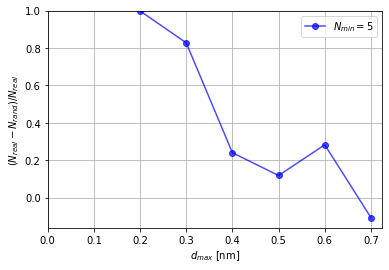

In [39]:
plt.plot(dmax_values, n_axis, 'bo-', alpha=0.7, label="$N_{min}=5$")
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("$(N_{real}-N_{rand})/N_{real}$")
plt.legend(loc=1)
plt.grid()
plt.xlim(left=0)
plt.ylim(top=1)

In [53]:
# find the way to iterate through the searches and change N_min using indexing
# by cutting off frequency values for N below the threshold
n_min_values = list(range(5, 25, 2))
n_min_values

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23]

In [65]:
# find number of clusters larger than n_min
# find all real clusters for all d_max values 
all_data = {}

for i, dm in enumerate(dmax_values):
    
    # create a dictionary
    all_data[dm] = {
        "real": {},
        "random averages": {},
        "random values": {}
    }
    
    # real clusters
    local_size_dist_file = f"{output_folder}przemek_{i}_dmax_{dm}_sizedist.txt"
    local_df = pandas.read_csv(local_size_dist_file, sep="\t")

    # go through n_min values and save them as integers in the "real" key
    for n in n_min_values:
        local_df_filtered = local_df[(local_df["Cluster Size(core)"]) >= n]
        loc_size_core = local_df_filtered["Frequency "]
        loc_clusters = loc_size_core.sum()
        all_data[dm]["real"][n] = loc_clusters
        
    # random clusters
    # create an empty list to append all the random 
    for n in n_min_values:
        all_data[dm]["random values"][n] = []
    
    # start from iterating through r to minimise pandas read csv function
    for random_run in range(random_runs):
        local_size_dist_file = f"{output_folder}przemek_{i}_dmax_{dm}_random_{random_run + 1}_sizedist.txt"
        local_df = pandas.read_csv(local_size_dist_file, sep="\t")

        # find the total number of clusters by summing up Size(core) column
        for n in n_min_values:
            local_df_filtered = local_df[(local_df["Cluster Size(core)"]) >= n]
            loc_size_core = local_df_filtered["Frequency "]
            loc_clusters = loc_size_core.sum()
            all_data[dm]["random values"][n].append(loc_clusters)
            
    # calculate the averages for each
    for n in n_min_values:
        all_data[dm]["random averages"][n] = np.array(all_data[dm]["random values"][n]).mean()

    
# print(f"All data: {all_data}")


All data: {0.2: {'real': {5: 432, 7: 186, 9: 109, 11: 76, 13: 58, 15: 37, 17: 31, 19: 23, 21: 18, 23: 15}, 'random averages': {5: 0.8, 7: 0.2, 9: 0.0, 11: 0.0, 13: 0.0, 15: 0.0, 17: 0.0, 19: 0.0, 21: 0.0, 23: 0.0}, 'random values': {5: [2, 1, 1, 0, 0], 7: [0, 1, 0, 0, 0], 9: [0, 0, 0, 0, 0], 11: [0, 0, 0, 0, 0], 13: [0, 0, 0, 0, 0], 15: [0, 0, 0, 0, 0], 17: [0, 0, 0, 0, 0], 19: [0, 0, 0, 0, 0], 21: [0, 0, 0, 0, 0], 23: [0, 0, 0, 0, 0]}}, 0.3: {'real': {5: 675, 7: 327, 9: 224, 11: 171, 13: 145, 15: 115, 17: 106, 19: 95, 21: 90, 23: 82}, 'random averages': {5: 116.4, 7: 46.6, 9: 19.0, 11: 5.8, 13: 1.8, 15: 0.2, 17: 0.0, 19: 0.0, 21: 0.0, 23: 0.0}, 'random values': {5: [225, 125, 88, 75, 69], 7: [24, 54, 57, 50, 48], 9: [4, 17, 20, 27, 27], 11: [0, 3, 10, 8, 8], 13: [0, 1, 3, 2, 3], 15: [0, 0, 1, 0, 0], 17: [0, 0, 0, 0, 0], 19: [0, 0, 0, 0, 0], 21: [0, 0, 0, 0, 0], 23: [0, 0, 0, 0, 0]}}, 0.4: {'real': {5: 1667, 7: 573, 9: 284, 11: 202, 13: 156, 15: 127, 17: 118, 19: 109, 21: 106, 23: 101}

Text(0.5, 1.0, 'Proportion of real clusters')

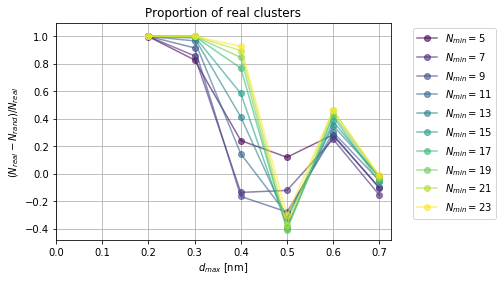

In [96]:
colors = plt.cm.viridis(np.linspace(0,1,len(n_min_values)))

for i, n in enumerate(n_min_values):
    
    # sort the data to get values for each n
    dm_local = np.array([])
    real_local = np.array([])
    random_local = np.array([])
    
    for dm in all_data:
        dm_local = np.append(dm_local, dm)
        real_local = np.append(real_local, all_data[dm]["real"][n])
        random_local = np.append(random_local, all_data[dm]["random averages"][n])
    

    y_values = (real_local - random_local)/real_local
    
    # plot
    plt.plot(dm_local, y_values, 'o-',color=colors[i], label="$N_{min}=%s$"%(n), alpha=0.6)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("$(N_{real}-N_{rand})/N_{real}$")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
plt.ylim(top=1.1)
plt.title("Proportion of real clusters")

Text(0.5, 1.0, 'Real Clusters across different $d_{max}$ values')

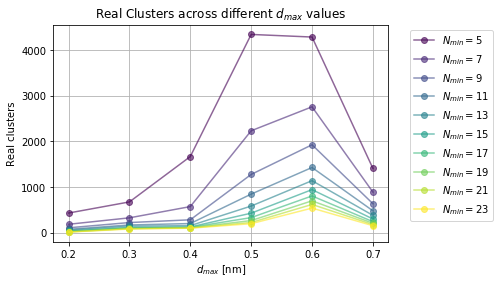

In [98]:
# plot the same graph but with total number of clusters
# TODO: find the volume of the given tip to show no. density instead

colors = plt.cm.viridis(np.linspace(0,1,len(n_min_values)))

for i, n in enumerate(n_min_values):
    
    # sort the data to get values for each n
    dm_local = np.array([])
    real_local = np.array([])
#     random_local = np.array([])
    
    for dm in all_data:
        dm_local = np.append(dm_local, dm)
        real_local = np.append(real_local, all_data[dm]["real"][n])
        random_local = np.append(random_local, all_data[dm]["random averages"][n])
    

#     y_values = (real_local - random_local)/real_local
    
    # plot
    plt.plot(dm_local, real_local, 'o-',color=colors[i], label="$N_{min}=%s$"%(n), alpha=0.6)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Real clusters")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
# plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Real Clusters across different $d_{max}$ values")

## Plotting cluster composition 

In [284]:
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Fm", "Ni", "P", "Cu", "Mn", "Si"]

compositions = {}

for i, dm in enumerate(dmax_values):
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # iterate through the core elements and import sums of the ions detected
    compositions[dm] = {}
    for ion in core_ions:
        compositions[dm][ion] = np.array(local_df[ion]).sum()
    
    # find total sum of all ions detected in the cluster search for the uncorrected composition
    compositions[dm]["total clusters"] = np.array(local_df.iloc[:, 3:-2]).sum()


Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

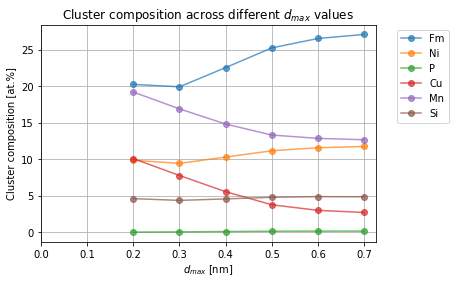

In [285]:
# plot using the data prepared 
for ion in core_ions:
    x_values = []
    y_values = []
    for i, dm in enumerate(dmax_values):
        x_values.append(dm)
        y_values.append(compositions[dm][ion]/compositions[dm]["total clusters"] * 100)
    
    plt.plot(x_values, y_values, 'o-', alpha=0.7, label=ion)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")

Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

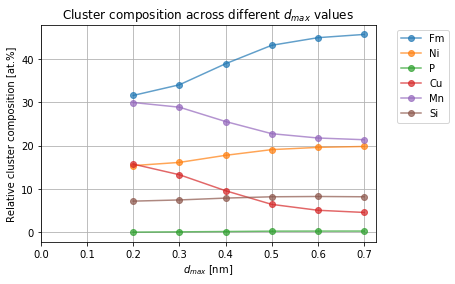

In [286]:
# find the corrected value (normalised core ion composition)
# create dictionary with place for d_max and list of core ion counts
core_ions_sum = {}
for dm in dmax_values:
    core_ions_sum[dm] = []

# iterate through the compositions data and append all ion counts into the list
for ion in core_ions:
    for i, dm in enumerate(dmax_values):
        core_ions_sum[dm].append(compositions[dm][ion])

# find the total sum of all core ions for a given d_max
for dm in core_ions_sum:
    core_ions_sum[dm] = np.array(core_ions_sum[dm]).sum()

# calculate relative composition of core ions in the clusters and plot them
for ion in core_ions:
    x_values = []
    y_values = []
    for i, dm in enumerate(dmax_values):
        x_values.append(dm)
        y_values.append(compositions[dm][ion]/core_ions_sum[dm] * 100)

    plt.plot(x_values, y_values, 'o-', alpha=0.7, label=ion)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")

Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

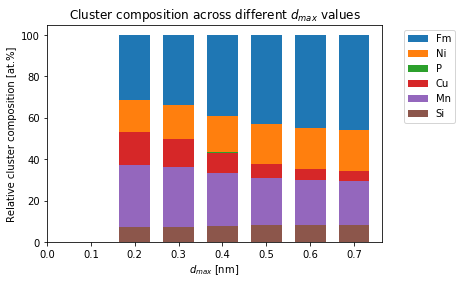

In [287]:
# the same graph but stacked bars
# calculate relative composition of core ions in the clusters and plot them
for i, ion in enumerate(core_ions):
    x_values = []
    y_values = []
    for dm in dmax_values:
        x_values.append(dm)
        y_values.append(compositions[dm][ion]/core_ions_sum[dm] * 100)

    # need to plot bar graphs on top of each other starting from 100%
    # and subtracting the values from the previous one
    # I use next value to avoid problems with labelling
    if i == 0:
        y_values_bar = np.ones(len(dmax_values)) * 100

    else:
        y_values_bar = next_values
    
    plt.bar(x_values, y_values_bar, alpha=1, label=ion, width=0.07)
    previous_values = y_values_bar
    
    next_values = y_values_bar - y_values

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")


Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

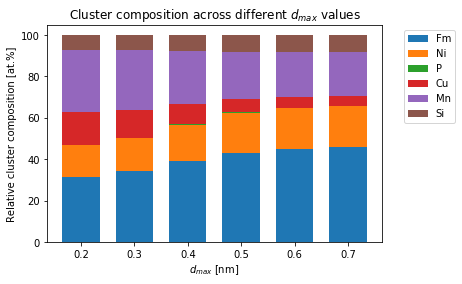

In [300]:
# the same graph but stacked bars - better method
# calculate relative composition of core ions in the clusters and plot them
core_ions = ["Fm", "Ni", "P", "Cu", "Mn", "Si"]
for i, ion in enumerate(core_ions):
    x_values = []
    y_values = []
    for dm in dmax_values:
        x_values.append(dm)
        y_values.append(compositions[dm][ion]/core_ions_sum[dm] * 100)
        
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    # need to plot bar graphs on top of each other starting from 100%
    # and subtracting the values from the previous one
    # I use next value to avoid problems with labelling
    if i == 0:
        plt.bar(x_values, y_values, alpha=1, label=ion, width=0.07)
        previous_y_values = y_values
    else:
        plt.bar(x_values, y_values, bottom=previous_y_values, alpha=1, label=ion, width=0.07)
        previous_y_values = y_values + previous_y_values


# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.grid()
# plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")


## Composition Correction

1. Removing certain elements from the calculations such as Fe.
2. Changing the amount of overlapped ions (peak 29: approx. 90% of Ni, and 10% of Fe) <- needs to be changed later to more accurate method!
3. Adding Fm to Ni column.

In [159]:
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}

In [168]:
# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "P", "Cu", "Mn", "Si"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
corrected_compositions = {}

for i, dm in enumerate(dmax_values):
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # iterate through the core elements and import sums of the ions detected
    corrected_compositions[dm] = {}
    for ion in core_ions:
        corrected_compositions[dm][ion] = np.array(local_df[ion]).sum()
    
    # find total sum of all ions detected in the cluster search for the uncorrected composition
    corrected_compositions[dm]["total clusters"] = np.array(local_df.iloc[:, 3:-2]).sum()

Copying and pasting previous scripts for plotting as it's exactly the same from now.

Text(0.5, 1.0, 'Corrected Cluster composition $d_{max}$ values')

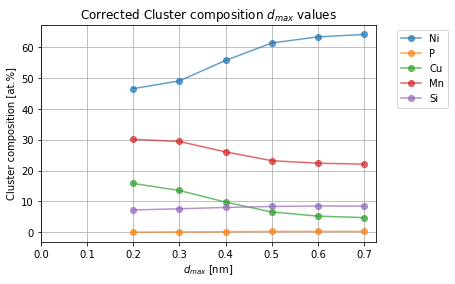

In [169]:
# plot using the data prepared 
for ion in core_ions:
    x_values = []
    y_values = []
    for i, dm in enumerate(dmax_values):
        x_values.append(dm)
        y_values.append(corrected_compositions[dm][ion]/corrected_compositions[dm]["total clusters"] * 100)
    
    plt.plot(x_values, y_values, 'o-', alpha=0.7, label=ion)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Corrected Cluster composition $d_{max}$ values")

Plotting relative cluster composition will be also different due to smaller Fm content.

Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

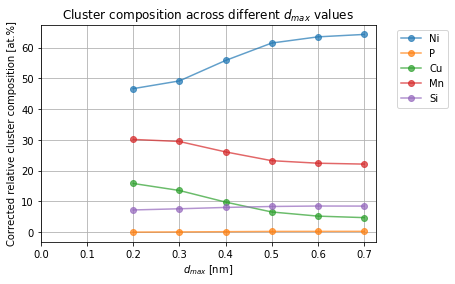

In [170]:
# find the corrected value (normalised core ion composition)
# create dictionary with place for d_max and list of core ion counts
core_ions_sum = {}
for dm in dmax_values:
    core_ions_sum[dm] = []

# iterate through the compositions data and append all ion counts into the list
for ion in core_ions:
    for i, dm in enumerate(dmax_values):
        core_ions_sum[dm].append(corrected_compositions[dm][ion])

# find the total sum of all core ions for a given d_max
for dm in core_ions_sum:
    core_ions_sum[dm] = np.array(core_ions_sum[dm]).sum()

# calculate relative composition of core ions in the clusters and plot them
for ion in core_ions:
    x_values = []
    y_values = []
    for i, dm in enumerate(dmax_values):
        x_values.append(dm)
        y_values.append(corrected_compositions[dm][ion]/core_ions_sum[dm] * 100)

    plt.plot(x_values, y_values, 'o-', alpha=0.7, label=ion)

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Corrected relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()
plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")

Text(0.5, 1.0, 'Cluster composition across different $d_{max}$ values')

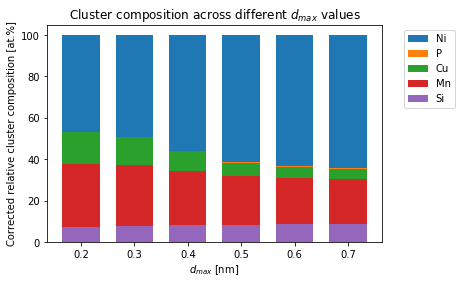

In [176]:
# the same graph but stacked bars
# calculate relative composition of core ions in the clusters and plot them
for i, ion in enumerate(core_ions):
    x_values = []
    y_values = []
    for dm in dmax_values:
        x_values.append(dm)
        y_values.append(corrected_compositions[dm][ion]/core_ions_sum[dm] * 100)

    # need to plot bar graphs on top of each other starting from 100%
    # and subtracting the values from the previous one
    # I use next value to avoid problems with labelling
    if i == 0:
        y_values_bar = np.ones(len(dmax_values)) * 100

    else:
        y_values_bar = next_values
    
    plt.bar(x_values, y_values_bar, alpha=1, label=ion, width=0.07)
    previous_values = y_values_bar
    
    next_values = y_values_bar - y_values

# adjust the plot    
plt.xlabel("$d_{max}$ [nm]")
plt.ylabel("Corrected relative cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.grid()
# plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition across different $d_{max}$ values")

## Composition vs cluster size

For a given cluster-stat file, plot the composition across all clusters and sort them by their size.


Text(0.5, 1.0, 'Cluster composition and size')

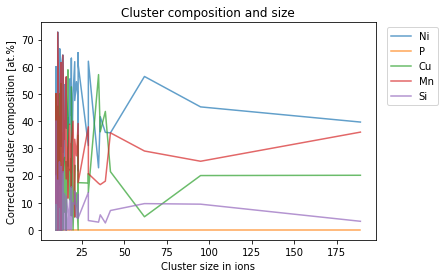

In [193]:
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}
n_min = 10

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "P", "Cu", "Mn", "Si"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    
    
    # iterate through rows and find their core ions and total ions values
    for core_ion in core_ions:
        x_values = local_df["Cluster Size"]
        y_values = local_df[core_ion]/local_df["Cluster Size"] * 100
        plt.plot(x_values, y_values, "-", alpha=0.7, label=core_ion)
    
    
    break

# adjust the plot    
plt.xlabel("Cluster size in ions")
plt.ylabel("Corrected cluster composition [at.%]")
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.grid()
# plt.xlim(left=0)
# plt.ylim(top=1.1)
plt.title("Cluster composition and size")

This data would be much clearer if:
- x axis showed index
- we used stacked bar chart
- we created a histogram with averaged cluster size bins

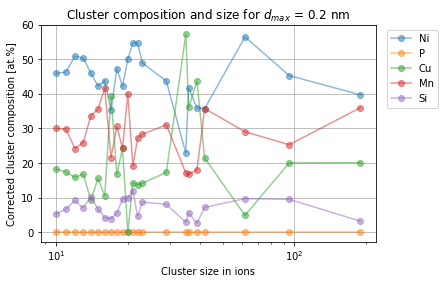

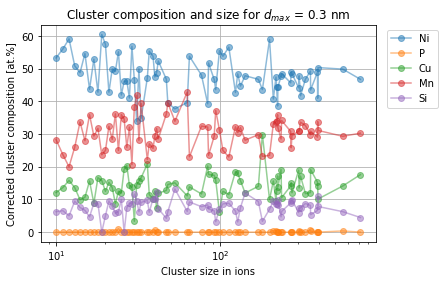

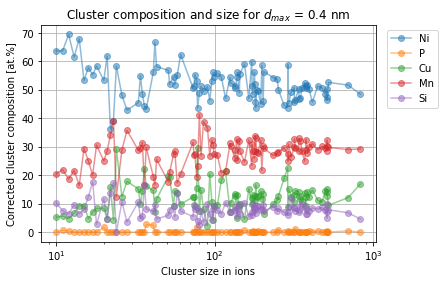

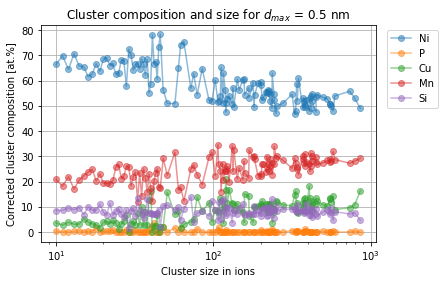

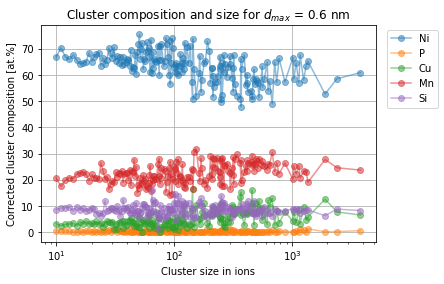

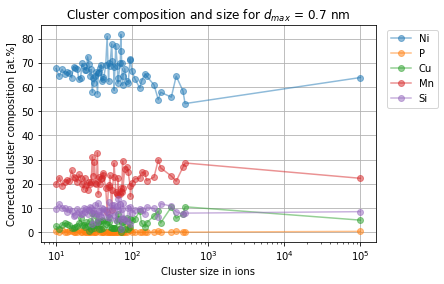

In [223]:
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}
n_min = 10

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["Ni", "P", "Cu", "Mn", "Si"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    plt.figure()
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    
    # iterate through rows and find their core ions and total ions values
    for core_ion in core_ions:
        x_values = local_df["Cluster Size"].unique()
        y_values = np.zeros(len(x_values))
        y_std = np.zeros(len(x_values))
        
        # for each cluster size find all clusters and calculate mean Ni content with stdev
        for i2, x in enumerate(iter(x_values)):
            all_for_one_size = local_df[local_df["Cluster Size"] == x][core_ion]
            y_values[i2] = all_for_one_size.mean() / x * 100
            y_std[i2] = all_for_one_size.std() / x * 100
            # TODO: think about how to plot st dev later on
        
        plt.semilogx(x_values, y_values, "o-", alpha=0.5, label=core_ion)
    
    # adjust the plot    
    plt.xlabel("Cluster size in ions")
    plt.ylabel("Corrected cluster composition [at.%]")
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.grid()
    # plt.xlim(left=0)
    # plt.ylim(top=1.1)
    plt.title("Cluster composition and size for $d_{max}$ = %s nm"%dm)
    plt.show()
    

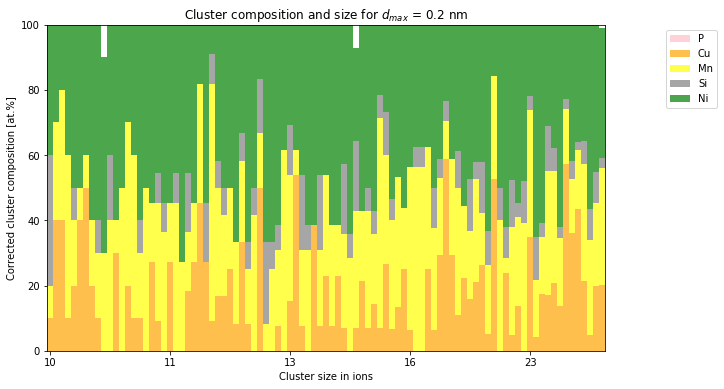

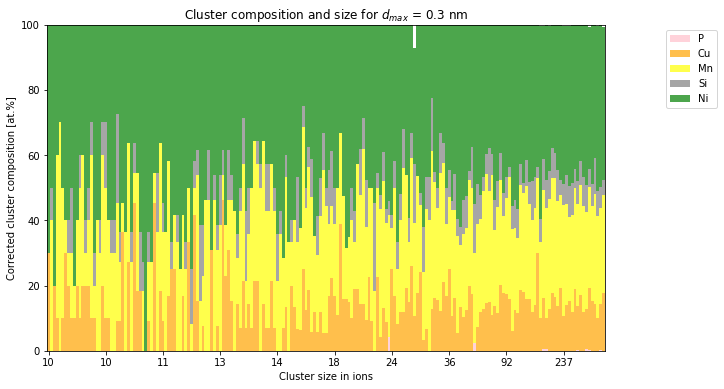

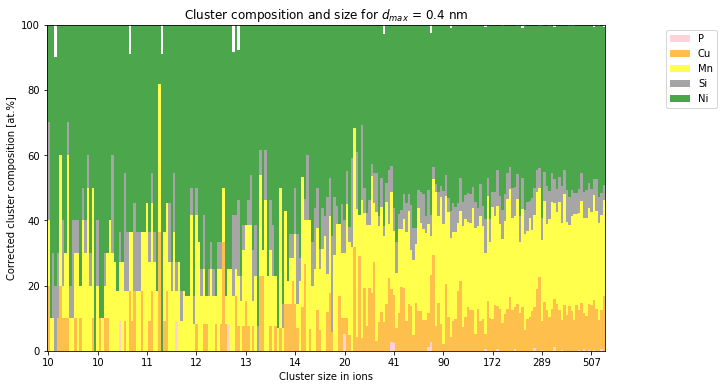

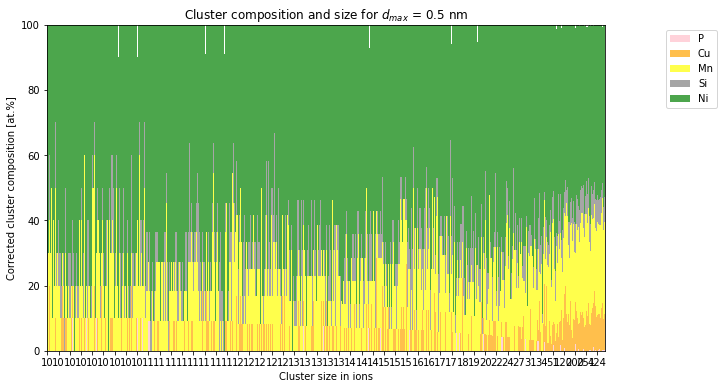

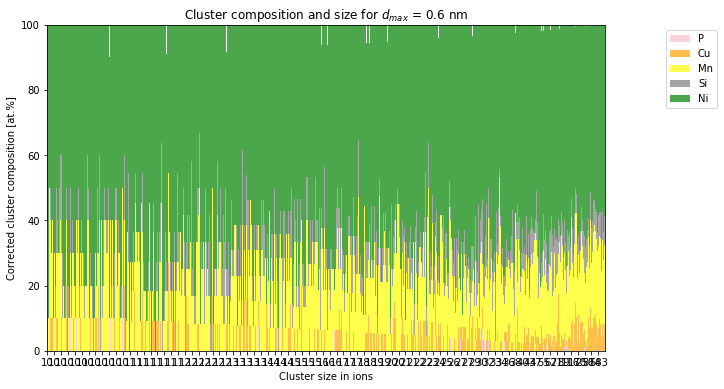

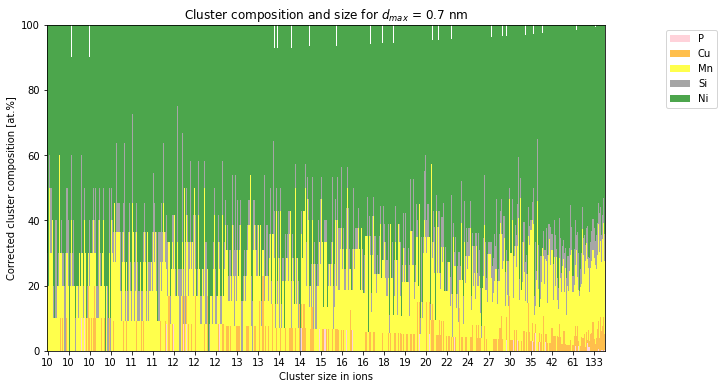

In [278]:
# same but with bar
# corrected compositions by excluding certain elements from the calculations
exclude_ions = ["Fe"]
overlap_ions = {"Fm": 0.92}
n_min = 10
core_ion_colors = {
    "Cu": "orange",
    "Ni": "green",
    "Mn": "yellow",
    "P": "pink",
    "Si": "grey"
}

# before reading the data and after creating pandas dataframes, drop specified columns
# retrieve the data needed from the cluster stats files for the composition plots
core_ions = ["P", "Cu", "Mn", "Si", "Ni"]

# create a new dictionary every time you run a correction to avoid correcting data more than once
dfs = {}
cluster_data = {}

for i, dm in enumerate(dmax_values):
    plt.figure(figsize=(10, 6))
    # open the cluster stats file and create pandas dataframe
    cluster_stats_file = xml_files[i].replace(".xml", "_cluster-stats.txt")
    local_df = pandas.read_csv(cluster_stats_file, sep="\t")
    
    # insert all the corrections in here
    # exclude (matrix) ions by deleting the column
    local_df = local_df.drop(exclude_ions, axis=1)
    # lower the amount of ions for each element that has overlap with matrix ions
    for overlap_ion in overlap_ions:
        local_df[overlap_ion] = round(local_df[overlap_ion] * overlap_ions[overlap_ion])
    # transfer the overlapping ions into "original" elements
    local_df["Ni"] = local_df["Ni"] + local_df["Fm"]
    # delete the overlaping ions by multiplying by 0 to keep the total amount of ions constant
    local_df["Fm"] = local_df["Fm"] * 0
    
    # add total ions in cluster value
    local_df["Cluster Size"] = local_df.iloc[:, 3:-2].sum(axis=1)
    
    # change n_min
    local_df = local_df[local_df["Cluster Size"] >= n_min]
    
    # sort it by size
    local_df = local_df.sort_values(by="Cluster Size")
    
    previous_y_values = []
    # iterate through rows and find their core ions and total ions values
    for i2, core_ion in enumerate(core_ions):
        cluster_size_values = local_df["Cluster Size"]
        x_values = np.arange(len(cluster_size_values))
        y_values = local_df[core_ion] / local_df["Cluster Size"] * 100
        
#         # for each cluster size find all clusters and calculate mean core ion content with stdev
#         for i3, x in enumerate(iter(x_values)):
#             all_for_one_size = local_df[local_df["Cluster Size"] == x][core_ion]
#             y_values[i3] = all_for_one_size.mean() / x * 100
#             y_std[i3] = all_for_one_size.std() / x * 100
#             # TODO: think about how to plot st dev later on
        
        if i2 == 0:
            plt.bar(x_values, y_values, width=1, alpha=0.7, label=core_ion, 
                    color=core_ion_colors[core_ion])
            previous_y_values = y_values
        else:
            plt.bar(x_values, y_values, bottom=previous_y_values, width=1, 
                    alpha=0.7, label=core_ion, color=core_ion_colors[core_ion])
            previous_y_values = previous_y_values + y_values
    
    # adjust the plot    
    plt.xlabel("Cluster size in ions")
    plt.ylabel("Corrected cluster composition [at.%]")
    
    # prepare the x axis - plot every 20th value
    tick = 20
    cluster_size_values = cluster_size_values.astype(int)
    plt.xticks(x_values[::tick], cluster_size_values[::tick])
    plt.legend(bbox_to_anchor=(1.1, 1))
#     plt.grid()
    plt.xlim(-0.5, len(y_values)-0.5)
    plt.ylim(0, 100)
    plt.title("Cluster composition and size for $d_{max}$ = %s nm"%dm)
    plt.show()


## Other graphs

